# Emotion Prediction from Facial Expressions using VGG19 Model

![](https://datasets.activeloop.ai/wp-content/uploads/2022/09/FER2013.png)

##  Listing Files in Kaggle Input Directory

In [102]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv
/kaggle/input/test-image1/20250427_212937.jpg
/kaggle/input/vgg19_emotion_classifier/tensorflow2/default/1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/test-image-2/1321477638.jpg
/kaggle/input/nishat-test-image/20250427_211949.jpg
/kaggle/input/nishat-test-image/20250427_205411.jpg
/kaggle/input/test-image/angry.jpg


## Importing Libraries

In [104]:
import math
import numpy as np
import pandas as pd

import cv2
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

## Loading the Dataset

In [105]:
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Exploring the Dataset

In [106]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [107]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [108]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

## Class Distribution Visualization

In [109]:
class_counts = (
    df.emotion
      .map(emotion_label_to_text)
      .value_counts()
      .rename_axis("emotion")
      .reset_index(name="count")
)
print(class_counts)

     emotion  count
0  happiness   8989
1    neutral   6198
2    sadness   6077
3       fear   5121
4      anger   4953
5   surprise   4002
6    disgust    547


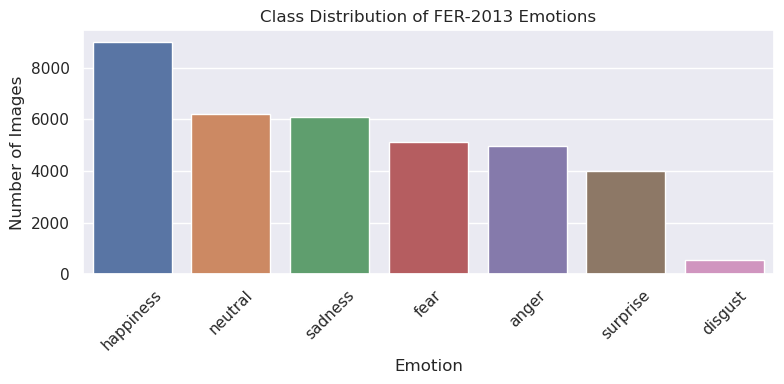

In [110]:
pyplot.figure(figsize=(8,4))
sns.countplot(
    x=df.emotion.map(emotion_label_to_text),
    order=class_counts.sort_values("count", ascending=False)["emotion"]
)
pyplot.title("Class Distribution of FER-2013 Emotions")
pyplot.xlabel("Emotion")
pyplot.ylabel("Number of Images")
pyplot.xticks(rotation=45)
pyplot.tight_layout()
pyplot.show()

In [111]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

##  Visualizing Sample Images from Each Emotion

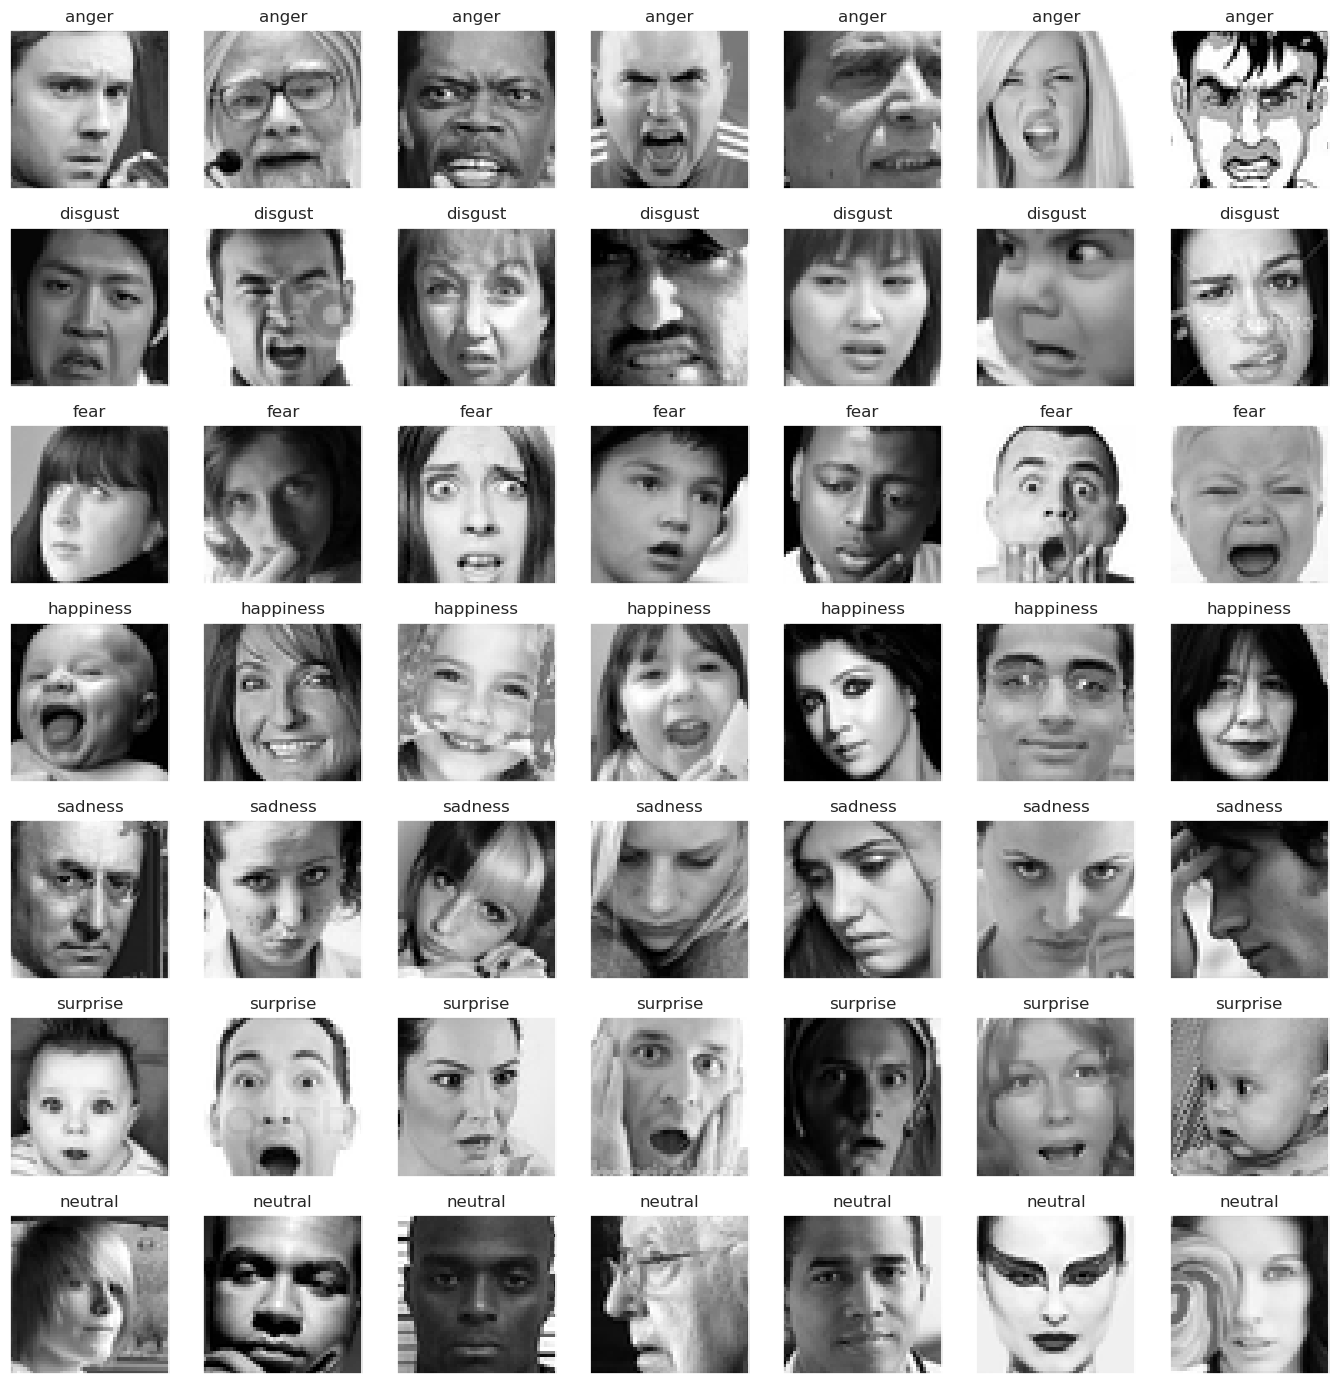

In [112]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

## Preparing Data for Neural Networks

In [114]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [115]:
img_array.shape

(35887, 48, 48)

In [116]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


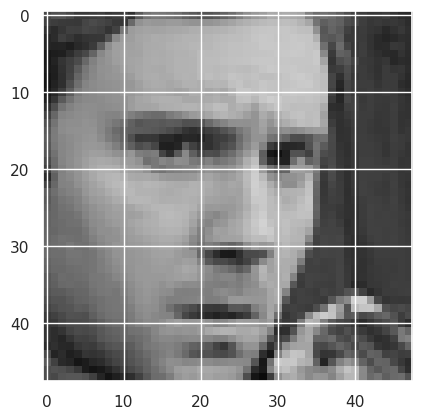

In [117]:
pyplot.imshow(img_features[0].astype(np.uint8));

##  Encoding Labels

In [118]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [119]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


## Splitting the Data into Training and Validation Sets

In [120]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features, 
                                                      img_labels, 
                                                      shuffle = True, 
                                                      stratify = img_labels, 
                                                      test_size = 0.1, 
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [121]:
del df
del img_features
del img_labels

In [122]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

## Normalizing the Images

In [123]:
X_train = X_train / 255.
X_valid = X_valid / 255.

##  Loading the Pre-trained VGG19 Model

In [124]:
vgg = tf.keras.applications.VGG19(weights = None,
                                  include_top = False,
                                  input_shape = (48, 48, 3))

weights_path = '/kaggle/input/vgg19_emotion_classifier/tensorflow2/default/1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg.load_weights(weights_path)

In [125]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

##  Building the Model

In [126]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

In [127]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

## Setting Callbacks

In [128]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

## Data Augmentation Setup

In [129]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

##  Model Compilation and Hyperparameters

In [130]:
# Defining batch size, epochs, and optimizer
batch_size = 32 
epochs = 50
optims = [optimizers.Adam(learning_rate = 0.0001, 
                          beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

## Model Training

In [131]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

batch_size = 32 
epochs = 50
optims = [optimizers.Adam(learning_rate = 0.0001, 
                          beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/50
1009/1009 [==============================] - 58s 56ms/step - loss: 1.4289 - accuracy: 0.4441 - val_loss: 1.2168 - val_accuracy: 0.5266 - lr: 1.0000e-04
Epoch 2/50
1009/1009 [==============================] - 55s 54ms/step - loss: 1.2233 - accuracy: 0.5366 - val_loss: 1.1560 - val_accuracy: 0.5715 - lr: 1.0000e-04
Epoch 3/50
1009/1009 [==============================] - 55s 54ms/step - loss: 1.1482 - accuracy: 0.5634 - val_loss: 1.0730 - val_accuracy: 0.6013 - lr: 1.0000e-04
Epoch 4/50
1009/1009 [==============================] - 55s 54ms/step - loss: 1.0871 - accuracy: 0.5906 - val_loss: 1.0090 - val_accuracy: 0.6216 - lr: 1.0000e-04
Epoch 5/50
1009/1009 [==============================] - 55s 54ms/step - loss: 1.0434 - accuracy: 0.6076 - val_loss: 1.0411 - val_accuracy: 0.6108 - lr: 1.0000e-04
Epoch 6/50
1009/1009 [==============================] - 55s 54ms/step - loss: 1.0107 - accuracy: 0.6195 - val_loss: 1.0526 - val_accuracy: 0.6102 - lr: 1.0000e-04
Epoch 7/50
1009/1009 [

In [132]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

##  Training History Visualization (Accuracy and Loss)

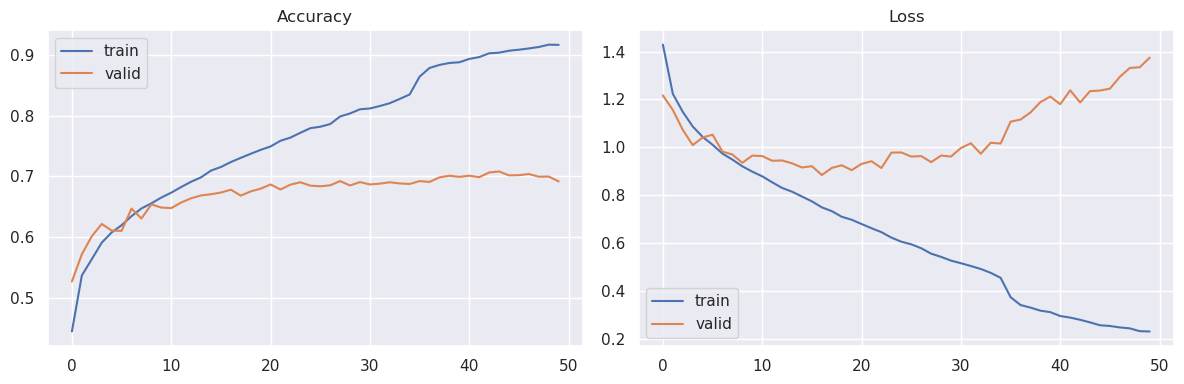

In [133]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

## Performance Distribution Visualization (Accuracy and Loss)

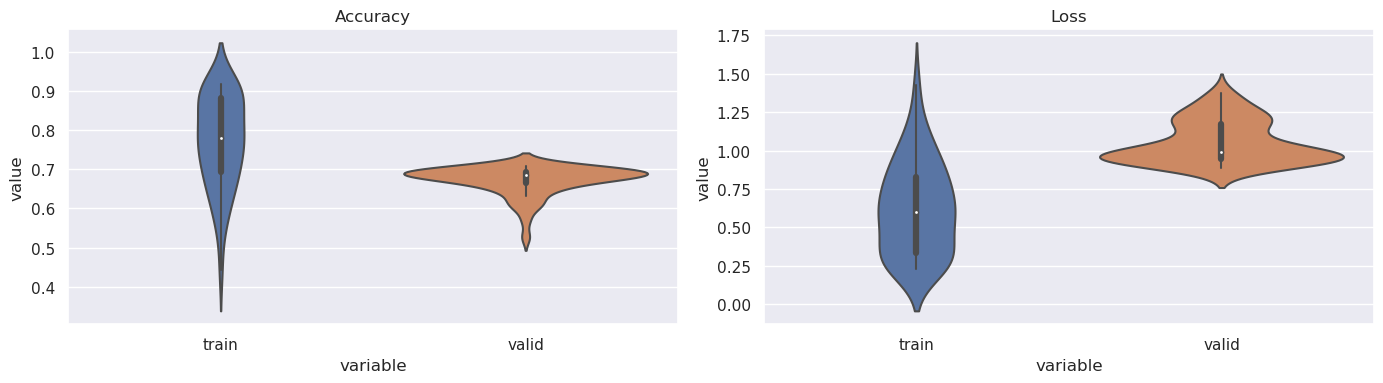

In [134]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

## Confusion Matrix and Classification Report

113/113 [==============================] - 2s 16ms/step
total wrong validation predictions: 1106


              precision    recall  f1-score   support

           0       0.60      0.68      0.64       495
           1       0.89      0.58      0.70        55
           2       0.56      0.58      0.57       512
           3       0.91      0.84      0.87       899
           4       0.62      0.49      0.54       608
           5       0.78      0.79      0.78       400
           6       0.61      0.74      0.67       620

    accuracy                           0.69      3589
   macro avg       0.71      0.67      0.68      3589
weighted avg       0.70      0.69      0.69      3589



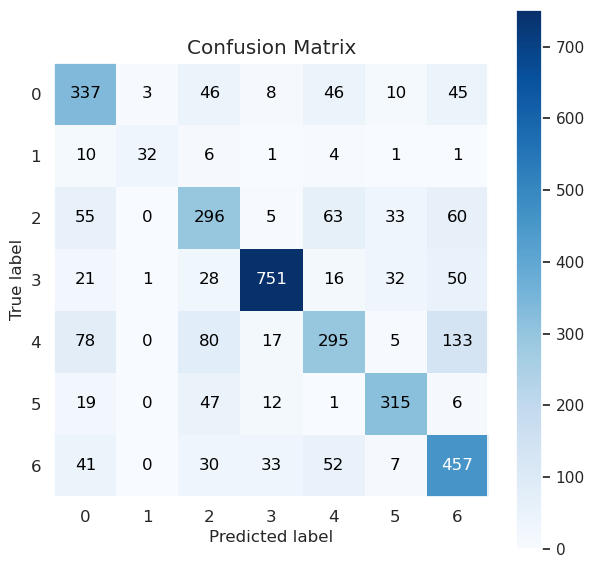

In [135]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

## Error Analysis for Specific Classes (e.g., Sadness and Neutral)

In [136]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

1/1 [==============================] - 0s 22ms/step


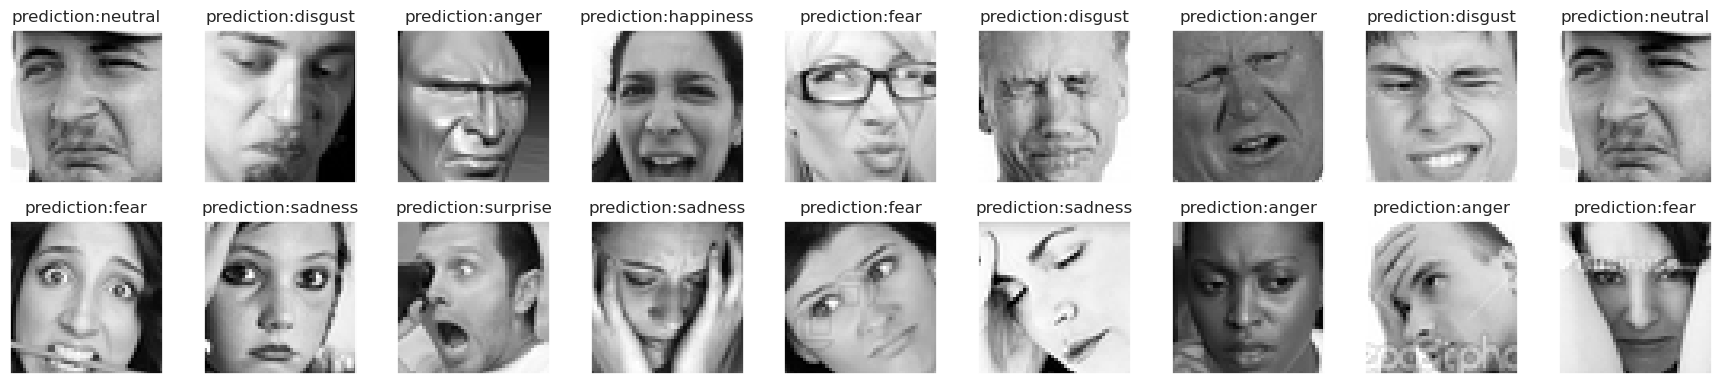

In [137]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

        ax.set_title(f"prediction:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)
        
        ax.set_title(f"prediction:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        pyplot.tight_layout()

##  Emotion Prediction from Image

1/1 [==============================] - 0s 151ms/step
Predicted Emotion: anger


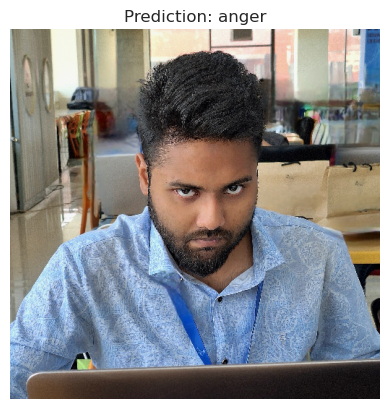

In [73]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

test_image_path = '/kaggle/input/test-image/angry.jpg'
img = cv2.imread(test_image_path)
if img is None:
    print("Error loading image.")
    exit()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (512, 512))
img_resized = img_resized / 255.0
img_resized = np.expand_dims(img_resized, axis=0)

prediction = model.predict(img_resized)

predicted_emotion = np.argmax(prediction, axis=1)[0]
predicted_emotion_text = emotion_label_to_text[predicted_emotion]

print(f"Predicted Emotion: {predicted_emotion_text}")

plt.imshow(img_resized[0])
plt.title(f"Prediction: {predicted_emotion_text}")
plt.axis('off')
plt.show()